# [Data Augmentation](https://github.com/kokchun/Deep-learning-AI21/blob/main/Lectures/Lec4-Data_augmentation.ipynb)

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets.mnist import load_data

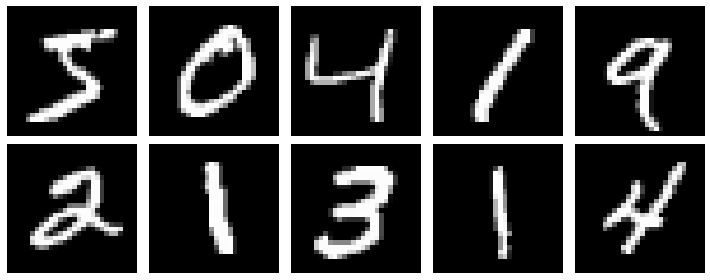

In [2]:
(X_train, y_train), (X_test, y_test) = load_data()
y_train, y_test = y_train.ravel(), y_test.ravel()

def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")
    fig.tight_layout()

plot_samples(X_train)

In [3]:
scaled_X_train = X_train.astype("float32") / 255
scaled_X_test = X_test.astype("float32") / 255
print(f"{X_train.min()=}, {X_train.max()=}")

X_train.min()=0, X_train.max()=255


In [9]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(
    scaled_X_train, y_train, test_size=1/6, random_state=42
)

In [10]:
X_train_val.shape

(50000, 28, 28)

## Data augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
# ImageDataGenerator requires rank 4 (amount of dimensions)
rank_4_X_train_val = X_train_val[:,:,:,None] # None creates a 4th dimension with ones
rank_4_X_val = X_val[:,:,:,None]
rank_4_X_train = scaled_X_train[:,:,:,None]
rank_4_X_test = scaled_X_test[:,:,:,None]

rank_4_X_train_val.shape

(50000, 28, 28, 1)

In [19]:
train_image_generator = ImageDataGenerator(
    rotation_range = 90,
    shear_range = .2,
    zoom_range = .2, # tho zoom might solve aspect ratio problem
    horizontal_flip = True,
    height_shift_range = .2, # check if can be negative range
    width_shift_range = .2, # check if can be negative range
)

# don't augment validation and test data
test_image_generator = ImageDataGenerator()

In [21]:
train_val_generator = train_image_generator.flow(rank_4_X_train_val, y_train_val, batch_size=32)

In [23]:
val_generator = test_image_generator.flow(rank_4_X_val, y_val, batch_size=32)

train_val_generator, val_generator

(<keras.preprocessing.image.NumpyArrayIterator at 0x17f0987c0>,
 <keras.preprocessing.image.NumpyArrayIterator at 0x294587be0>)

2
(32, 28, 28, 1)


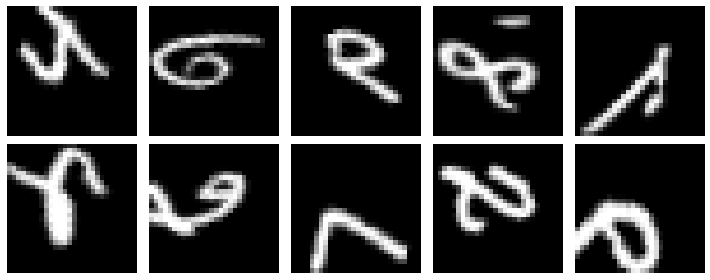

In [30]:
print(len(train_val_generator.next()))
print(train_val_generator.next()[0].shape) # 1 batch of 32 samples
plot_samples(train_val_generator.next()[0])

array([2, 5, 6, 0, 2, 8, 4, 8, 8, 4, 9, 5, 2, 4, 9, 3, 2, 7, 3, 6, 1, 2,
       9, 4, 3, 9, 0, 3, 8, 3, 0, 1], dtype=uint8)

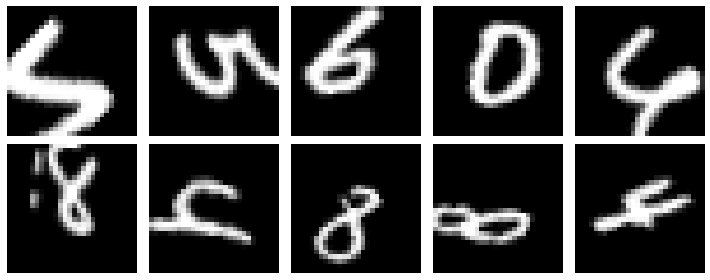

In [31]:
sample_batch = train_val_generator.next()
plot_samples(sample_batch[0])
sample_batch[1]

In [37]:
train_image_generator_v2 = ImageDataGenerator(
    rotation_range = 10,
    shear_range = .2,
    zoom_range = .2,
    height_shift_range = .2,
    width_shift_range = .2,
)

In [38]:
train_val_generator_v2 = train_image_generator_v2.flow(rank_4_X_train_val, y_train_val, batch_size=32)

array([2, 5, 6, 2, 7, 3, 9, 9, 0, 2], dtype=uint8)

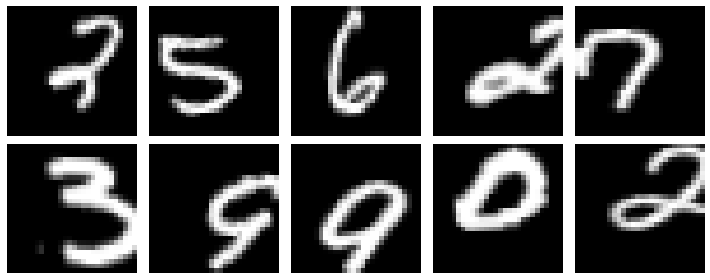

In [41]:
sample_batch_v2 = train_val_generator_v2.next()
plot_samples(sample_batch_v2[0])
sample_batch_v2[1][:10]

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate=.001, drop_rate=.5, kernels=[32,32]):
    adam = Adam(learning_rate=learning_rate)
    model = Sequential(name='cnn_model')

    for number_kernel in kernels:
        conv_layer = Conv2D(number_kernel, kernel_size = (3,3), activation='relu', kernel_initializer='he_normal', input_shape=X_train.shape[1:])
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size=(2,2), strides=2))

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['acc'])

    return model

In [43]:
model = CNN_model(drop_rate=.5)
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                          

2022-04-28 10:05:52.506178: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-28 10:05:52.506596: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Train on augmented data

In [45]:
steps_per_epoch =  int(len(X_train_val)/32)
validation_steps =  int(len(X_val)/32)
steps_per_epoch, validation_steps

(1562, 312)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor='val_acc', mode='max', patience=5, restore_best_weights=True)

model.fit(train_val_generator_v2, 
          steps_per_epoch=steps_per_epoch, 
          epochs=100, 
          callbacks=[early_stopper],
          validation_data = val_generator,
          validation_steps=validation_steps)

Epoch 1/100


2022-04-28 10:30:14.813949: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-28 10:30:15.053861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1556/1562 [============================>.] - ETA: 0s - loss: 0.6524 - acc: 0.7858

2022-04-28 10:30:26.285313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1562/1562 [==============================] - 13s 8ms/step - loss: 0.6516 - acc: 0.7861 - val_loss: 0.1205 - val_acc: 0.9643
Epoch 2/100
1562/1562 [==============================] - 12s 8ms/step - loss: 0.2829 - acc: 0.9105 - val_loss: 0.0896 - val_acc: 0.9730
Epoch 3/100
1562/1562 [==============================] - 12s 8ms/step - loss: 0.2255 - acc: 0.9299 - val_loss: 0.0776 - val_acc: 0.9759
Epoch 4/100
1562/1562 [==============================] - 11s 7ms/step - loss: 0.1967 - acc: 0.9379 - val_loss: 0.0877 - val_acc: 0.9731
Epoch 5/100
1562/1562 [==============================] - 11s 7ms/step - loss: 0.1726 - acc: 0.9458 - val_loss: 0.0556 - val_acc: 0.9838
Epoch 6/100
1562/1562 [==============================] - 11s 7ms/step - loss: 0.1620 - acc: 0.9488 - val_loss: 0.0633 - val_acc: 0.9810
Epoch 7/100
1562/1562 [==============================] - 11s 7ms/step - loss: 0.1533 - acc: 0.9524 - val_loss: 0.0514 - val_acc: 0.9834
Epoch 8/100
1562/1562 [==============================] - 12s

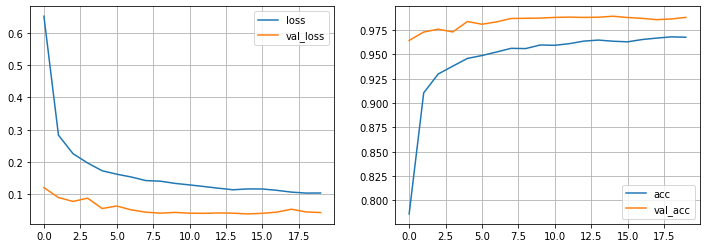

In [47]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2,figsize=(12,4))
    metrics[['loss', 'val_loss']].plot(ax=ax[0], grid=True)
    metrics[['acc', 'val_acc']].plot(ax=ax[1], grid=True)
metrics = pd.DataFrame(model.history.history)
plot_metrics(metrics)

In [48]:
train_generator = train_image_generator_v2.flow(rank_4_X_train, y_train, batch_size=32)
model = CNN_model(drop_rate=.5)
model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs = 15)

Epoch 1/15
   6/1562 [..............................] - ETA: 19s - loss: 2.8184 - acc: 0.1406     

2022-04-28 10:45:00.882785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1562/1562 [==============================] - 11s 7ms/step - loss: 0.6720 - acc: 0.7804
Epoch 2/15
1562/1562 [==============================] - 10s 7ms/step - loss: 0.2973 - acc: 0.9079
Epoch 3/15
1562/1562 [==============================] - 10s 7ms/step - loss: 0.2278 - acc: 0.9281
Epoch 4/15
1562/1562 [==============================] - 10s 7ms/step - loss: 0.1976 - acc: 0.9386
Epoch 5/15
1562/1562 [==============================] - 10s 7ms/step - loss: 0.1772 - acc: 0.9434
Epoch 6/15
1562/1562 [==============================] - 10s 6ms/step - loss: 0.1658 - acc: 0.9479
Epoch 7/15
1562/1562 [==============================] - 10s 6ms/step - loss: 0.1502 - acc: 0.9533
Epoch 8/15
1562/1562 [==============================] - 10s 6ms/step - loss: 0.1454 - acc: 0.9540
Epoch 9/15
1562/1562 [==============================] - 10s 6ms/step - loss: 0.1398 - acc: 0.9568
Epoch 10/15
1562/1562 [==============================] - 11s 7ms/step - loss: 0.1309 - acc: 0.9597
Epoch 11/15
1562/1562 [=======

2022-04-28 10:52:09.424762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.97      0.99      0.98       974
           9       0.99      0.96      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



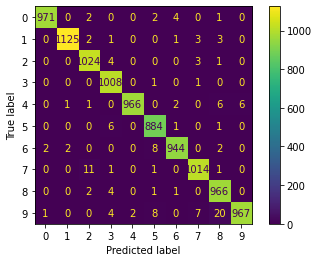

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(rank_4_X_test)
y_pred_argmax = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_argmax))
cm = confusion_matrix(y_test, y_pred_argmax)
ConfusionMatrixDisplay(cm).plot()